In [1]:
import pandas as pd
from glob import glob
from lifelines.utils import concordance_index as lfcindex
import matplotlib.pyplot as plt
import seaborn as sns
from samecode.survival.plot import KMPlot
from shap.plots import colors
colors = [colors.blue_rgb, colors.red_rgb]

/home/shenwanxiang/anaconda3/envs/compass/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
y = pd.read_csv('../Clinical_Transformer/data/ITRP_clinical.csv', index_col=0)
y = y[(~y.OS_Months.isna()) & (~y.OS_Event.isna()) ] # & (~y.TMB.isna())
y['time'] = y['OS_Months']
y['event'] = y['OS_Event']

y.cohort.unique()

y.shape

(860, 28)

In [3]:
y.cohort.value_counts().index.to_list()

['IMVigor210',
 'Liu',
 'SU2CLC1',
 'Rose',
 'Gide',
 'Riaz',
 'Allen',
 'MGH',
 'SU2CLC2',
 'Hugo',
 'Snyder']

In [4]:
seeds = [24, 42,64]
len(y)

860

## TMB performance

In [5]:
res = []
for seed in seeds:
    
    dfr = y['TMB'].to_frame(name = 'score')
    dfr['group'] = dfr['score'].apply(lambda x:'High-TMB' if x >=10 else 'Low-TMB')

    dfr['score_type'] = 'TMB'
    dfr['score_seed'] = seed
    dfr['learning_type'] = 'TMB'
    dfr['model_name'] = 'TMB'
    dfr = dfr.join(y[['time', 'event','cohort', 'cancer_type']])
    res.append(dfr)
tmb = pd.concat(res)

## CSP Risk Score

In [6]:
res = []
for seed in seeds:
    csp = pd.read_csv('../CSP_surival_model/csp_itrp.csv',
                      index_col=0) #['risk_probability'].to_frame('score')

    csp.columns = ['score', 'group']
    csp.group = csp.group.map({'high':'High-risk', 'low':'Low-risk'})

    csp['score_type'] = 'risk_probability'
    csp['score_seed'] = seed
    csp['learning_type'] = 'checkpoint prediction'
    csp['model_name'] = 'CSP survival model'
    csp = csp.join(y[['time', 'event','cohort', 'cancer_type']])
    res.append(csp)
csp = pd.concat(res)

In [7]:
csp.groupby('model_name')[['score', 'time']].corr()

score     time
model_name                                
CSP survival model score  1.00000 -0.20522
                   time  -0.20522  1.00000

## COMPASS Response Probability

In [8]:
# res = []
# for s in seeds:
    
#     dfr = pd.read_csv('../../02_leave_one_cohort_out/conceptor_run/LOCO_a100/LOCO_PFT_%s/source_performance.tsv' % s,sep = '\t', index_col = 0)
#     # if s == 42:
#     #     dfr = pd.read_csv('../../../05_feature_explaination/tmpignore_O2_new/03_PFT_score_loco/00_finetune_loco/LOCO_v100s/LOCO_PFT_%s//source_performance.tsv' % s,sep = '\t', index_col = 0)
#     # else:
#     #     dfr = pd.read_csv('../../02_leave_one_cohort_out/conceptor_run/LOCO_a100/LOCO_PFT_%s/source_performance.tsv' % s,sep = '\t', index_col = 0)

#     dfr = dfr['1'].to_frame('score')
#     dfr['group'] = dfr['score'].apply(lambda x:'Responder' if x >=0.5 else 'Non-responder')

#     dfr['score_type'] = 'response_probability'
#     dfr['score_seed'] = s
#     dfr['learning_type'] = 'checkpoint prediction'
#     dfr['model_name'] = 'COMPASS PFT model'
#     dfr = y[['time', 'event','cohort', 'cancer_type']].join(dfr) 
#     res.append(dfr)
# comps = pd.concat(res)

In [9]:
res = []
for s in seeds:
    csvs = glob(f'../COMPASS_survival/LOCO_PFT/*/seed_{s}/test_data.csv')
    for csv in csvs:
        dfr = pd.read_csv(csv, index_col = 0)
    
        dfr = dfr['1'].to_frame('score')
        dfr['group'] = dfr['score'].apply(lambda x:'Responder' if x >=0.5 else 'Non-responder')
    
        dfr['score_type'] = 'response_probability'
        dfr['score_seed'] = s
        dfr['learning_type'] = 'checkpoint prediction'
        dfr['model_name'] = 'COMPASS PFT model'
        dfr = dfr.join(y[['time', 'event','cohort', 'cancer_type']])
        res.append(dfr)
comps = pd.concat(res)

In [10]:
comps.groupby('model_name')[['score', 'time']].corr()

score      time
model_name                                 
COMPASS PFT model score  1.000000  0.269746
                  time   0.269746  1.000000

## CoxPH Linear Survival Model

In [11]:
Model_NAMES = ['Fges29 + CoxPH',
              'ssGSEA43 + CoxPH',
              'COMPASS + CoxPH']

Model_PATHS = ['05_Fges29 + CoxPH',
              '06_ssGSEA43 + CoxPH',
              '07_COMPASS + CoxPH',]

res = []
for seed in seeds:
    for i in range(3):
        mpt = Model_PATHS[i]
        p = f'../Clinical_Transformer/{mpt}/*/test_data.csv'
        dfr = pd.concat([pd.read_csv(csv, index_col=0) for csv in glob(p)])[['risk_score', 'Pred_Risk']]
        dfr.columns = ['score', 'group']
        dfr['score_type'] = 'risk_probability'
        dfr['score_seed'] = seed

        dfr['learning_type'] = 'Linear Survival'
        dfr['model_name'] = Model_NAMES[i]
        dfr = dfr.join(y[['time', 'event','cohort', 'cancer_type']])
        res.append(dfr)
coxph = pd.concat(res)

In [12]:
coxph.groupby('model_name')[['score', 'time']].corr()

score      time
model_name                                
COMPASS + CoxPH  score  1.000000 -0.147545
                 time  -0.147545  1.000000
Fges29 + CoxPH   score  1.000000 -0.209060
                 time  -0.209060  1.000000
ssGSEA43 + CoxPH score  1.000000 -0.150968
                 time  -0.150968  1.000000

## ClinicalTransformer Baseline Survival model

In [13]:
Model_NAMES = ['Vanilla ClinicalTransformer',
              'ssGSEA43 + ClinicalTransformer',
              'COMPASS + ClinicalTransformer',]

Model_PATHS = ['VanillaClinicalTransformer',
              'ssGSEA43ClinicalTransformer',
              'COMPASSClinicalTransformer',]

res = []
for i in range(3):
    mpt = Model_PATHS[i]
    for seed in seeds:
        p = f'../Clinical_Transformer/04_Clinical_Transformer/Results/ResultsBaseline/{mpt}/*/full_{seed}/test_data.csv'
        dfr = pd.concat([pd.read_csv(csv, index_col=0) for csv in glob(p)])
        dfr = dfr[['β','population']]

        dfr.columns = ['score', 'group']
        dfr.group = dfr.group.map({'High Score':'High-score', 'Low Score':'Low-score'})

        dfr['score_type'] = 'β value'
        dfr['score_seed'] = seed
        dfr['learning_type'] = 'BaselineSurvival'
        dfr['model_name'] = Model_NAMES[i]
        dfr = dfr.join(y[['time', 'event','cohort', 'cancer_type']])
        
        res.append(dfr)
ct_baseline = pd.concat(res)

In [14]:
ct_baseline.groupby('model_name')[['score', 'time']].corr()

score      time
model_name                                              
COMPASS + ClinicalTransformer  score  1.000000  0.278485
                               time   0.278485  1.000000
Vanilla ClinicalTransformer    score  1.000000  0.288750
                               time   0.288750  1.000000
ssGSEA43 + ClinicalTransformer score  1.000000  0.257080
                               time   0.257080  1.000000

## ClinicalTransformer TransferLearning Survival model

In [15]:
Model_NAMES = ['Vanilla ClinicalTransformer',
              'ssGSEA43 + ClinicalTransformer',
              'COMPASS + ClinicalTransformer',]

Model_PATHS = ['VanillaClinicalTransformer',
              'ssGSEA43ClinicalTransformer',
              'COMPASSClinicalTransformer',]

res = []
for i in range(3):
    mpt = Model_PATHS[i]
    for seed in seeds:
        p = f'../Clinical_Transformer/04_Clinical_Transformer/Results/ResultsTransferLearning/{mpt}/*/full_{seed}/*/test_data.csv'
        dfr = pd.concat([pd.read_csv(csv, index_col=0) for csv in glob(p)])
        dfr = dfr[['β','population']]

        dfr.columns = ['score', 'group']
        dfr.group = dfr.group.map({'High Score':'High-score', 'Low Score':'Low-score'})

        dfr['score_type'] = 'β value'
        dfr['score_seed'] = seed
        dfr['learning_type'] = 'TransferLearningSurvival'
        dfr['model_name'] = Model_NAMES[i]
        dfr = dfr.join(y[['time', 'event','cohort', 'cancer_type']])
        
        res.append(dfr)
ct_transfer = pd.concat(res)

In [16]:
ct_transfer.groupby('model_name')[['score', 'time']].corr()

score      time
model_name                                              
COMPASS + ClinicalTransformer  score  1.000000  0.325010
                               time   0.325010  1.000000
Vanilla ClinicalTransformer    score  1.000000  0.345168
                               time   0.345168  1.000000
ssGSEA43 + ClinicalTransformer score  1.000000  0.308080
                               time   0.308080  1.000000

In [17]:
cohort_list = y.cohort.value_counts().index.to_list()[:] #
test_results = pd.concat([ct_transfer,ct_baseline, csp, comps, tmb]) #coxph, 
test_results = test_results[test_results.cohort.isin(cohort_list)]
test_results.to_csv('./results/All_method_raw_test.csv')

In [18]:
test_results.model_name.unique()

array(['Vanilla ClinicalTransformer', 'ssGSEA43 + ClinicalTransformer',
       'COMPASS + ClinicalTransformer', 'CSP survival model',
       'COMPASS PFT model', 'TMB'], dtype=object)

In [19]:
import numpy as np
def calculate_cindex(df1):

    df = df1.copy()
    st = df.score_type.unique()
    assert len(st) == 1, 'Should be unique score type!'

    df = df[~df.score.isna()]
    if len(df) == 0:
        return np.nan
    
    if len(df) == 0:
        return np.nan
    
    if 'risk' in st[0]:
        ## VIP: should be negative risk-score
        ## see: https://lifelines.readthedocs.io/en/latest/lifelines.utils.html
        cindex = lfcindex(df['time'], -df['score'], df['event'])
    else:
        cindex = lfcindex(df['time'], df['score'], df['event'])
    return cindex

In [20]:
g = test_results.groupby(['cohort', 'learning_type', 'model_name', 'score_seed', ]).apply(calculate_cindex).unstack()
mean_cindex = g.mean(axis=1).to_frame(name='cindex').reset_index()
std_cindex = g.std(axis=1).to_frame(name='cindex').reset_index()
dfm = pd.pivot_table(data = mean_cindex, index = ['learning_type', 'model_name'],
               columns = 'cohort', values = 'cindex')

dfm_std = pd.pivot_table(data = std_cindex, index = ['learning_type', 'model_name'],
               columns = 'cohort', values = 'cindex')

dfm1 = dfm[cohort_list].round(3).astype(str)
dfm_std1 = dfm_std[cohort_list].round(3).astype(str)

dfm1 = dfm1 + '±'  + dfm_std1

s = y.cohort.value_counts()
s = s.index + '(n=' + s.astype(str) + ')'
dfm1.columns = dfm1.columns.map(s.to_dict())


x1 = dfm.mean(axis=1).to_frame(name = 'Average')
x2 = dfm.std(axis=1).to_frame(name = 'Average')

x = x1.round(3).astype(str) + '±' + x2.round(3).astype(str)

dfm1 = dfm1.join(x).T

In [21]:
dfm1.to_excel('./results/Summary_test_results_all.xlsx')

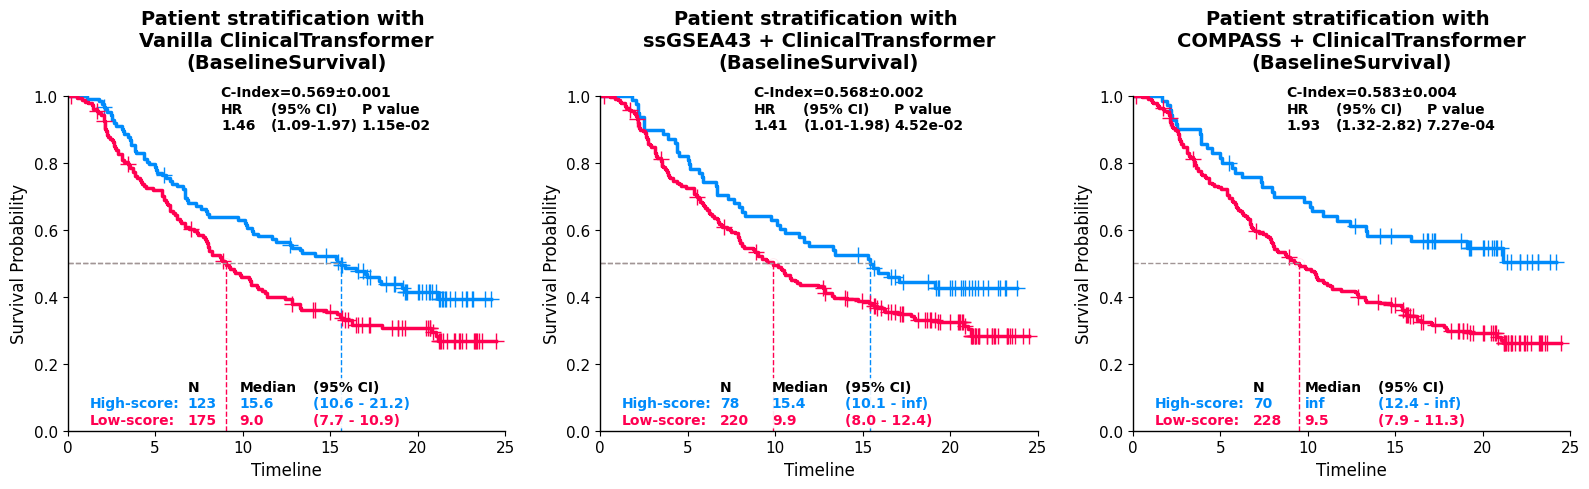

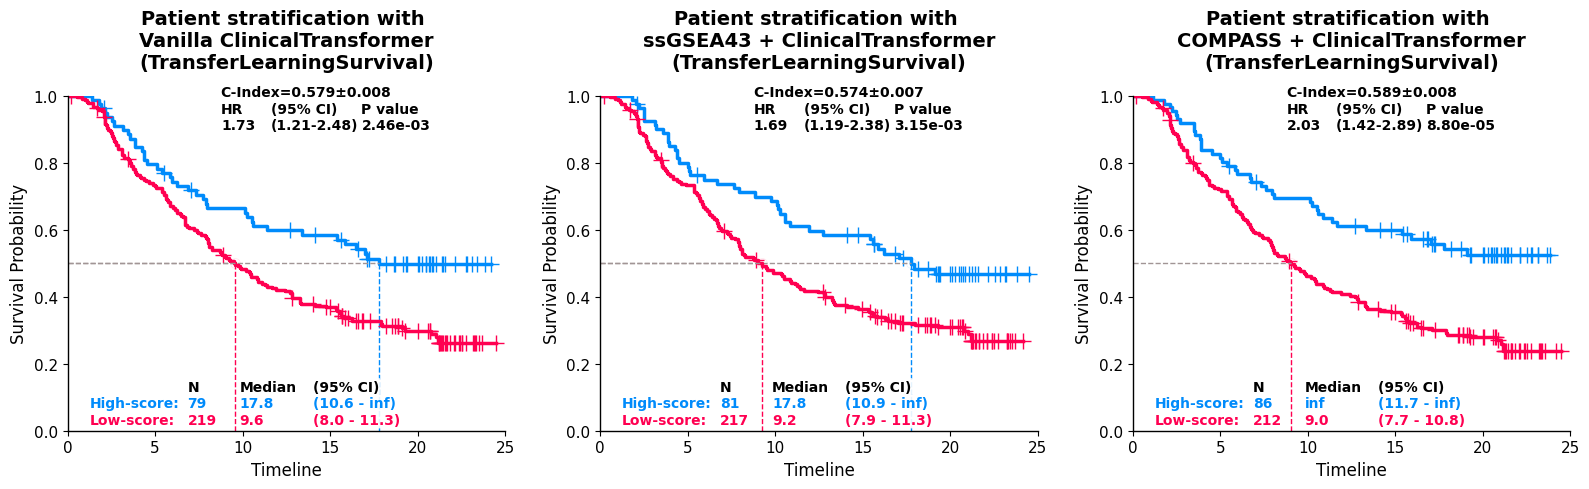

In [22]:
cohort = 'IMVigor210'
xmax = 25
model_names = ['Vanilla ClinicalTransformer', 
               'ssGSEA43 + ClinicalTransformer', 
               'COMPASS + ClinicalTransformer']

dfus = [ct_baseline, ct_transfer]
comparisons = [[ 'Low-score', 'High-score','']]

for dfu in dfus:    
    dfc1 = dfu[dfu.cohort == cohort]
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 5))

    for ax, model_name in zip(axes, model_names):

        dfp1 = dfc1[dfc1.model_name == model_name]
        desc = dfp1.learning_type.unique()[0]
        title = f'Patient stratification with \n{model_name}\n({desc})'

        group = dfp1.reset_index().groupby(['Index'])['group'].apply(lambda x:x.mode()[0]).to_frame()
        time = dfp1.reset_index().groupby(['Index'])['time'].apply(lambda x:x.mode()[0]).to_frame()
        event = dfp1.reset_index().groupby(['Index'])['event'].apply(lambda x:x.mode()[0]).to_frame()
        score = dfp1.reset_index().groupby(['Index'])['score'].apply(lambda x:x.mean()).to_frame()
        dfp2 = group.join(time).join(event).join(score)

        KMPlot(dfp2, time='time', event='event', label=["group"]).plot(
            ax=ax,
            colors=colors, #['r', 'b'],
            comparisons=comparisons,
            title = title,

            #ci_show=True,
            #ci_alpha=0.10,       
            hr_color = 'black',
            x_legend = 0.05, y_legend = 0.12, legend_font_size=10, 
            x_hr_legend = 0.3, y_hr_legend = 0.95, hr_font_size=10,
            linewidth=2.5
        );

        for poly in ax.collections:
            poly.set_alpha(0.1)  # 修改置信区间阴影透明度

        cindex = dfp1.groupby('score_seed').apply(lambda x:lfcindex(x['time'], 
                                                                    x['score'], 
                                                                    x['event']))
        
        cindex_format = "C-Index={:.3f}±{:.3f}".format(cindex.mean(),cindex.std() )
        
    #     for t in ax.texts:  
    #         t.set_fontweight('normal')
        ax.set_ylim(0,1)
        ax.set_xlim(0,xmax)
        ax.xaxis.label.set_fontweight('normal')
        ax.yaxis.label.set_fontweight('normal')

        ax.text(0.35, 1, cindex_format, 
                transform=ax.transAxes,   weight='bold', fontsize=10, color='black');

        ax.set_title(title, fontsize=14,  pad=20)  # pad=20 weight='bold',
        ax.title.set_fontweight('bold')

    sns.despine(offset=0)
    fig.tight_layout(w_pad=2)